# 4.4.5. Agreement between classification metrics

Simulation:

* Create dataset with some randomized features
* Apply SVM classifier
* Compute metrics
* Repeat 50 times
* Report correlation between metrics

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from functools import partial
from tqdm import tqdm

from sklearn.datasets import make_classification
from sklearn.manifold import MDS
from sklearn.svm import SVC
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage

from metrics.classification import get_micro_auroc, get_macro_auroc, MCC, kappaU, kappaL, kappaQ, GM, Accuracy, sF1, hF1, multiclass_cm

def confmat_metric(gt, pred, metric):
    cm = multiclass_cm(gt, pred)
    return metric(cm)

In [2]:
np.random.seed(1)

metrics = {
    'muAUROC': get_micro_auroc,
    'MAUROC': get_macro_auroc,
    'Accuracy': partial(confmat_metric, metric=Accuracy),
    'GM': partial(confmat_metric, metric=GM),
    'sF1': partial(confmat_metric, metric=sF1),
    'hF1': partial(confmat_metric, metric=hF1),
    'MCC': partial(confmat_metric, metric=MCC),
    'kappaU': partial(confmat_metric, metric=kappaU),
    'kappaL': partial(confmat_metric, metric=kappaL),
    'kappaQ': partial(confmat_metric, metric=kappaQ),
}

results = []
for _ in tqdm(range(50)):
    n_classes = np.random.randint(2, 6)
    n_samples = np.random.randint(500, 5001)
    n_features = np.random.randint(n_classes+1, 10)
    n_informative = np.random.randint(n_classes, n_features)
    flip_y = np.random.random()*0.15
    class_sep = np.random.random()*0.8
    weights = 0.2+np.random.random((n_classes,))
    weights /= weights.sum()
    
    X, Y = make_classification(n_samples=n_samples, 
                               n_features=n_features, 
                               n_informative=n_informative,
                               n_redundant=0,
                               n_classes=n_classes, 
                               flip_y=flip_y, 
                               class_sep=class_sep,
                               weights=weights)
    
    n_train = int(len(X)*0.9)
    clf = SVC(probability=True)
    clf.fit(X[:n_train], Y[:n_train])
    pred = clf.predict_proba(X[n_train:])
    
    results.append([metric(Y[n_train:], pred) for metric in metrics.values()])

results = np.array(results)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:16<00:00,  2.74s/it]


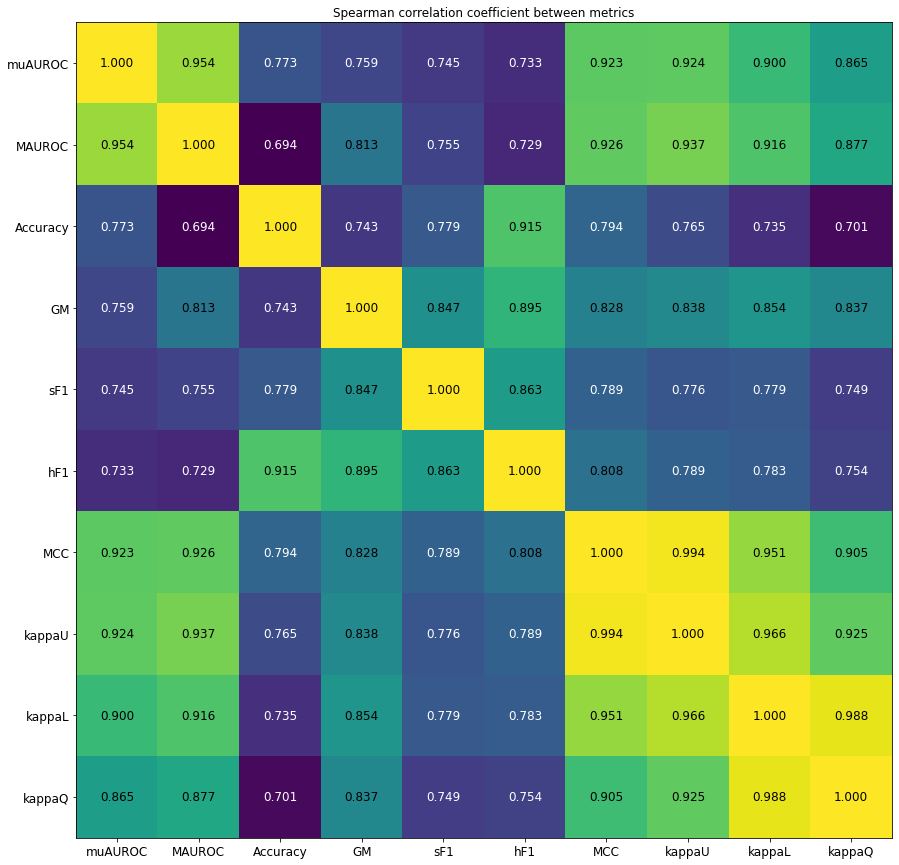

45
[[6.00000000e+00 7.00000000e+00 5.57022809e-03 2.00000000e+00]
 [8.00000000e+00 9.00000000e+00 1.15246098e-02 2.00000000e+00]
 [0.00000000e+00 1.00000000e+00 4.60984394e-02 2.00000000e+00]
 [1.00000000e+01 1.10000000e+01 6.31932773e-02 4.00000000e+00]
 [2.00000000e+00 5.00000000e+00 8.48019208e-02 2.00000000e+00]
 [1.20000000e+01 1.30000000e+01 9.15606242e-02 6.00000000e+00]
 [3.00000000e+00 4.00000000e+00 1.52632716e-01 2.00000000e+00]
 [1.40000000e+01 1.60000000e+01 1.79894129e-01 4.00000000e+00]
 [1.50000000e+01 1.70000000e+01 2.25725361e-01 1.00000000e+01]]


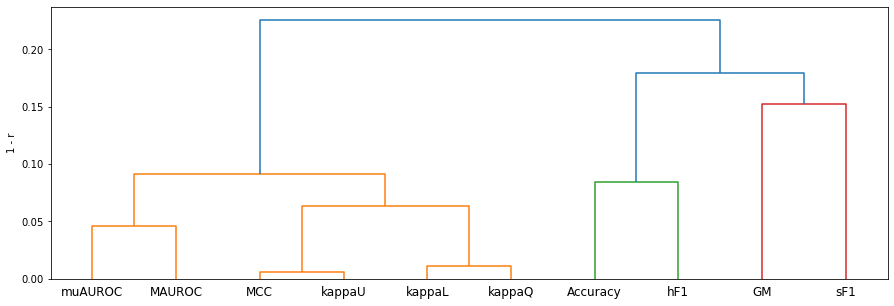

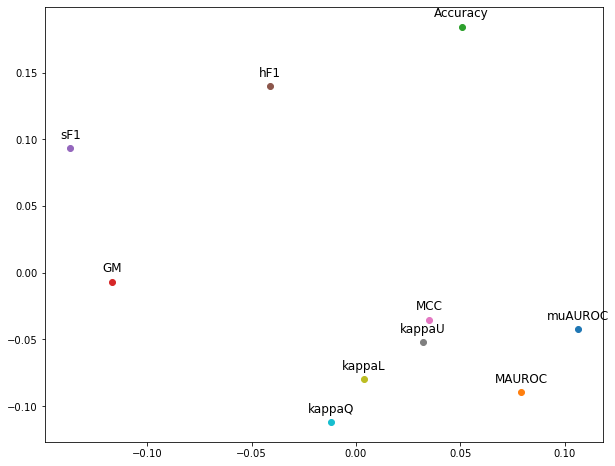

In [4]:
spearman_corr = np.zeros((results.shape[1],results.shape[1]))
spearman_pval = np.zeros((results.shape[1],results.shape[1]))
for i in range(results.shape[1]):
    for j in range(results.shape[1]):
        r, p = spearmanr(results[:,i], results[:,j])
        spearman_corr[i, j] = r
        spearman_pval[i, j] = p
        
plt.figure(figsize=(15,15))
plt.imshow(spearman_corr)
for i in range(spearman_corr.shape[0]):
    for j in range(spearman_corr.shape[1]):
        color = 'k' if spearman_corr[i, j] > 0.8 else 'w'
        plt.text(j, i, f'{spearman_corr[i, j]:.3f}', ha="center", va="center", color=color, fontsize='large')
plt.xticks(range(spearman_corr.shape[1]), labels=list(metrics.keys()), fontsize='large')
plt.yticks(range(spearman_corr.shape[1]), labels=list(metrics.keys()), fontsize='large')
plt.title(f"Spearman correlation coefficient between metrics")
plt.show()

y = []
for i in range(spearman_corr.shape[0]-1):
    for j in range(i+1, spearman_corr.shape[0]):
        y.append(1-spearman_corr[i,j])
print(len(y))

z = linkage(y, method='average')
print(z)
plt.figure(figsize=(15,5))
dendrogram(z, labels=list(metrics.keys()))
plt.ylabel('1 - r')
plt.show()

np.random.seed(0)
mds = MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(1-spearman_corr)

plt.figure(figsize=(10,8))
for i,key in enumerate(metrics.keys()):
    plt.plot(coords[i, 0], coords[i, 1], 'o')
    plt.text(coords[i, 0], coords[i, 1]+0.01, key, ha="center", va="center", color='k', fontsize='large')
plt.show()